# Fugue with Trino

Have questions? Chat with us on Github or Slack:

[![Homepage](https://img.shields.io/badge/fugue-source--code-red?logo=github)](https://github.com/fugue-project/fugue)
[![Slack Status](https://img.shields.io/badge/slack-join_chat-white.svg?logo=slack&style=social)](http://slack.fugue.ai)

The Fugue Trino integration provides the following benefits:

* significantly faster development of SQL queries
* ability to break up pieces of logic
* ability to test SQL without running on the warehouse
* for Python-users, reduced boilerplate when querying warehouse data for further manipulation in Python engines (Pandas, Spark, Dask, Ray)

This page is divided into three parts: setup, SQL usage, and Python usage of the BigQuery integration.

## Setup

Some of the configurations can be set using the `engine_conf` Fugue uses. For more information on configuring engines, see the section on [engine initialization](https://fugue-tutorials.readthedocs.io/tutorials/advanced/execution_engine.html#initialization). An example can be found below when creating the `TrinoClient`.

### Installation

To install the Fugue Trino integration, `fugue-warehouses` needs to be installed separately. Note that `fugue-warehouses` only supports Python 3.8 and up.

```
pip install fugue-warehouses[trino]
```

### Connecting to Trino

Creating a client requires a default catalog, though queries can be made across different catalogs. The default catalog is for persisting temp tables (more information below).

```python
import os
from fugue_trino import TrinoClient

client = TrinoClient.get_or_create(
    {
        "fugue.trino.catalog": "cloud_storage",
        "fugue.trino.user": "kevin@konvex.io/accountadmin",
        "fugue.trino.host": "fugue-fugue2.trino.galaxy.starburst.io",
        "fugue.trino.password": os.environ["TRINO_PASSWORD"],        
    }
)
```

### Environment Requirement

The Fugue Trino integration will sometimes persist intermediate tables to either prevent querying data again, or in order to pass the data to distributed backends.

You MUST set a catalog to store temporary intermediate tables. The default schema name is `fugue_temp_schema`. You can change it through the Fugue config `fugue.trino.temp_schema`. It is strongly recommended to set a default expiration for this schema, `1 day` is a reasonable value. Setting this will be dependent on the underlying engine Trino is running on.

## Trino for SQL Users

The purpose of the Trino integration is to allow users to use FugueSQL syntax on top of Trino tables. If you are not familiar with FugueSQL, you can check the [FugueSQL in 10 minutes section](../../quick_look/ten_minutes_sql.ipynb). FugueSQL has added syntax over traditional SQL, allowing developers to break up queries and iterate faster. In addition, FugueSQL supports DuckDB as a local backend, which allows users to test SQL queries locally before running them on Trino. This saves a lot of time when working on big data. Again, traditional SQL will work fine, but the advantage of FugueSQL is the sped up iteration so this tutorial will focus on the iteration process.

Demoing the Trino integration is hard because of the infrastructure that needs to be setup. We used [Starburst](https://www.starburst.io/) with two catalogs. We queried BigQuery tables while writing temporary tables in Google Cloud storage. We recommend asking questions in our Slack channel because there can be specific configurations depeding on the underlying engines.

### Querying the Table

Now, we are ready to run SQL queries using the [FugueSQL Jupyter Extension](https://github.com/fugue-project/fugue-jupyter), which gives us the `%%fsql` cell magic in Jupyter. We just need to add `trino` after `%%fsql` to specify the Trino engine. In the query below, we use Jinja templating to specify the table we are working on.

In [2]:
table = "bigquery.fugue.usa_1910_2013"
n=3

In [3]:
%%fsql trino
SELECT name, gender, SUM(number) AS ct
  FROM {{table}}
 GROUP BY name, gender
 PRINT

,name:str,gender:str,ct:long
0,Sadie,F,80812
1,Marie,F,461275
2,Edith,F,211143
3,Helen,F,894826
4,Ethel,F,195052
5,Hazel,F,187622
6,Opal,F,55892
7,Doris,F,448027
8,Elizabeth,F,1490772
9,Ruby,F,301607


## Breaking Up Queries

We just want to get the top 3 rows for each gender so that we can iterate on smaller data before running on the full dataset. FugueSQL has a keyword `TAKE` for this operation. In order to use a table in a following cell, we can use the `YIELD` keyword instead of `PRINT`. This helps us iterate on queries piece by piece.

In [4]:
%%fsql trino
df = SELECT name, gender, SUM(number) AS ct
       FROM {{table}}
      GROUP BY name, gender
 
names = TAKE {{n}} ROWS FROM df PREPARTITION BY gender PRESORT ct DESC
YIELD DATAFRAME

We can even view the `YIELDED` dataframe in Python. The Python section later will detail more how we can continue to work on a query result in Pandas.

In [5]:
names

,name:str,gender:str,ct:long
0,Mary,F,3728041
1,Patricia,F,1567405
2,Elizabeth,F,1490772
3,James,M,4924235
4,John,M,4818746
5,Robert,M,4703680


Though notice the DataFrame above is not Pandas. To bring to Pandas, just use the Fugue API

In [6]:
import fugue.api as fa
fa.as_pandas(names)

,name,gender,ct
0,Mary,F,3728041
1,Patricia,F,1567405
2,Elizabeth,F,1490772
3,James,M,4924235
4,John,M,4818746
5,Robert,M,4703680


### FugueSQL Extensions

One of the advantages of FugueSQL is keywords like `TRANSFORM` and `OUTPUT` that allow Python functions to be invoked by FugueSQL. There are some built-in extensions. For example, we can use the `seaborn` visualization library. This will bring the results of the query to Pandas, and then generate the lineplot without the need for additional boilerplate code.

Custom extensions can also be written, and are a highly encouraged form of contribution to Fugue. If you are interested in adding an extension, please join the Fugue [Slack](http://slack.fugue.ai).

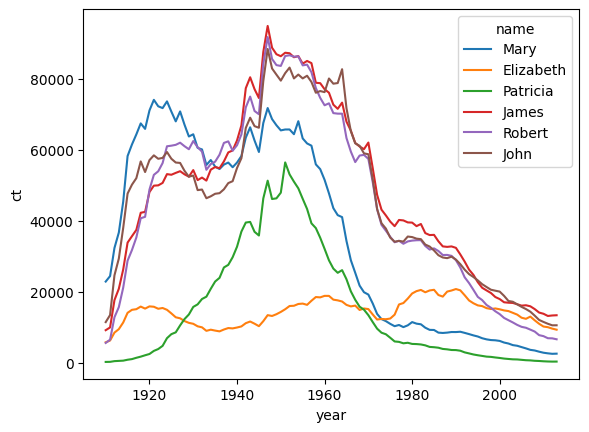

In [7]:
%%fsql trino
SELECT name, year, SUM(number) AS ct
  FROM {{table}}
 WHERE name IN (SELECT name FROM names)
 GROUP BY name, year
 ORDER BY year
OUTPUT USING sns:lineplot(x="year",y="ct",hue="name")

### Productionizing SQL Queries

To use the Trino integration in Python scripts, we can put everything together when done iterating using the `fugue_sql` function. We just need to remove the intermediate `YIELD` keywords.

In [8]:
import fugue.api as fa
res = fa.fugue_sql("""
SELECT name, gender, SUM(number) AS ct
  FROM {{table}}
 GROUP BY name, gender

names = TAKE {{n}} ROWS PREPARTITION BY gender PRESORT ct DESC

SELECT name, year, SUM(number) AS ct
  FROM {{table}}
 WHERE name IN (SELECT name FROM names)
 GROUP BY name, year
 ORDER BY year
""", engine="trino", table=table, n=n)

We can convert this BigQuery Table result to a Pandas DataFrame.

In [9]:
fa.as_pandas(res).head()

,name,year,ct
0,Patricia,1991,3420
1,Mary,1992,8447
2,Elizabeth,1993,17583
3,Mary,1993,8104
4,Mary,1994,7737


### Iterating on Big Data

One of the common use cases is to sample the Trino table into a smaller DataFrame that can be worked on using DuckDB. This allows users to prototype SQL queries before running on the full table.

In [10]:
%%fsql trino
SELECT *
  FROM {{table}}
 SAMPLE 1 PERCENT
  YIELD LOCAL DATAFRAME AS test

Now we can use DuckDB for further iteration. This prevents us from having to query the table.

In [11]:
%%fsql duckdb
SELECT *
  FROM test
 PRINT 5 ROWS

,state:str,gender:str,year:long,name:str,number:long
0,SC,F,1910,Rose,49
1,TX,F,1910,Marguerite,42
2,CT,F,1911,Gertrude,46
3,WI,F,1911,Marion,66
4,KY,F,1912,Bernice,45


## Trino for Python Users

### Combining Trino and Distributed Compute

One of the strengths of FugueSQL is being able to seamlessly combine Python and SQL expressions. In the example below, we want to get the median value of each state in the data. This function is easy to express in Pandas, but will take a lot more code in SQL. We can use the `transform()` function in the Fugue API and apply this function on the Trino table using Spark/Dask/Ray as the backend.

This set-up can be used for distributed profiling or machine learning inference on top of Trino data.

In [13]:
import pandas as pd
from typing import List, Any

# schema: *
def median(df:pd.DataFrame) -> List[List[Any]]:
    return [[df.state.iloc[0], df.number.median()]]

fa.transform(
    ("trino", """SELECT state, number
    FROM bigquery.fugue.usa_1910_2013"""),
    median,
    partition="state",
    engine="dask"
).compute().head()